In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from scipy import signal
from scipy import stats

import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# for svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

In [19]:
import pandas as pd
import time

start_time1 = time.time()
data = pd.read_excel(r'..\..\dataArticle\publicData\data.xlsx')
data.columns
data

Index(['Person', 'State', 'x', 'y', 'z'], dtype='object')

,Person,State,x,y,z
0,33.0,Jogging,-0.694638,12.680544,0.503953
1,33.0,Jogging,5.012288,11.264028,0.953424
2,33.0,Jogging,4.903325,10.882658,-0.081722
3,33.0,Jogging,-0.612916,18.496431,3.023717
4,33.0,Jogging,-1.184970,12.108489,7.205164
...,...,...,...,...,...
1048570,7.0,Standing,-8.080000,5.090000,-0.690000
1048571,7.0,Standing,-8.120000,5.520000,-0.800000
1048572,7.0,Standing,-7.890000,5.790000,-0.720000
1048573,7.0,Standing,-7.890000,5.980000,-0.270000


In [3]:
G = 9.80665
data['x'] = data['x'].div(G)
data['y'] = data['y'].div(G)
data['z'] = data['z'].div(G)
data

,Person,State,x,y,z
0,33.0,Jogging,-0.070833,1.293056,0.051389
1,33.0,Jogging,0.511111,1.148611,0.097222
2,33.0,Jogging,0.500000,1.109722,-0.008333
3,33.0,Jogging,-0.062500,1.886111,0.308333
4,33.0,Jogging,-0.120833,1.234722,0.734722
...,...,...,...,...,...
1048570,7.0,Standing,-0.823931,0.519036,-0.070360
1048571,7.0,Standing,-0.828010,0.562883,-0.081577
1048572,7.0,Standing,-0.804556,0.590416,-0.073420
1048573,7.0,Standing,-0.804556,0.609790,-0.027532


In [4]:
data = data.drop(columns = 'Person')
df = data.groupby(['State'])
df.first()

,x,y,z
State,,,
Downstairs,-0.004167,0.508333,0.663889
Jogging,-0.070833,1.293056,0.051389
Sitting,0.265126,0.985046,0.105556
Standing,-0.191707,1.004420,-0.023611
Upstairs,1.031945,0.441667,-0.386111
Walking,0.086111,0.816667,0.284722


In [5]:
Downstairs = df.get_group(('Downstairs'))
Jogging = df.get_group(('Jogging'))
Sitting = df.get_group(('Sitting'))
Standing = df.get_group(('Standing'))
Upstairs = df.get_group(('Upstairs'))
Walking = df.get_group(('Walking'))

len(Downstairs)
len(Jogging)
len(Sitting)
len(Standing)
len(Upstairs)
len(Walking)

97813

325975

54876

44541

118589

406776

In [6]:
stand = Standing
len(stand)
sit = Sitting
len(sit)
jog = Jogging
len(jog)
walk = Downstairs.append(Upstairs).append(Walking)
len(walk)

44541

54876

325975

623178

In [7]:
#Check nan value & remove 
len(walk.index)

walk = walk.dropna()
walk.index = pd.RangeIndex(len(walk.index))
len(walk.index)
walk.isnull().sum().sum()

type(walk)

623178

623177

0

pandas.core.frame.DataFrame

In [25]:
# Split dataset to 2 parts: Train (60%) - Test (40%)
#Fs = 20Hz

frame = 200
stride = 100 
ratio = 0.6

def splitDatasetToTrain(dataAction):
    return [dataAction[i:i+frame] for i in range(0, int(len(dataAction)*ratio), stride)]

def splitDatasetToTest(dataAction):
    return [dataAction[i:i+frame] for i in range(int(len(dataAction)*ratio),len(dataAction),stride) 
                    if i+frame<=len(dataAction)]

X_stand_train = splitDatasetToTrain(stand)
X_stand_test = splitDatasetToTest(stand)


X_sit_train = splitDatasetToTrain(sit)
X_sit_test = splitDatasetToTest(sit)

X_jog_train = splitDatasetToTrain(jog)
X_jog_test = splitDatasetToTest(jog)

X_walk_train = splitDatasetToTrain(walk)
X_walk_test = splitDatasetToTest(walk)

print ('X_stand_train: ', len(X_stand_train))
print ('X_stand_test: ', len(X_stand_test))

print ('X_sit_train: ', len(X_sit_train))
print ('X_sit_test: ', len(X_sit_test))

print ('X_jog_train: ', len(X_jog_train))
print ('X_jog_test: ', len(X_jog_test))

print ('X_walk_train: ', len(X_walk_train))
print ('X_walk_test: ', len(X_walk_test))

X_stand_train:  268
X_stand_test:  177
X_sit_train:  330
X_sit_test:  218
X_jog_train:  1956
X_jog_test:  1302
X_walk_train:  3740
X_walk_test:  2491


In [30]:
# Create a function & don't know how many variables => use splat operator.

def mergeArrayAction (*dataActions):
    data = {
        "data": [],
        "label": []
    }
    index = 0
    for dataAction in dataActions: 
        for act in dataAction: 
            data["data"].append(np.array(acts))
            data["label"].append(index)
        index += 1
    return data

dataTrain = mergeArrayAction(
    X_stand_train,
    X_sit_train,
    X_jog_train,
    X_walk_train, 
)

dataTest = mergeArrayAction(
    X_stand_test,
    X_sit_test,
    X_jog_test,
    X_walk_test
)

train_data = dataTrain["data"]
train_label = dataTrain["label"]

test_data = dataTest["data"]
test_label = dataTest["label"]

print('train-data length: ', len(train_data))
print('train-label length: ', len(train_label))
print('test-data length: ', len(test_data))
print('test-label length: ', len(test_label))

train-data length:  6294
train-label length:  6294
test-data length:  4188
test-label length:  4188


In [10]:
LABELS = [ 
    "STANDING",
    "SITTING",
    "JOGGING",
    "WALKING"
]

In [11]:
X_train = np.array(train_data)
X_test = np.array(test_data)

y_train = np.array(train_label)
y_test = np.array(test_label)

In [12]:
# Input Data 

training_data_count = len(X_train)  # 6294 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 4188 testing series
n_steps = len(X_train[0])  # 200 timesteps per series
n_input = len(X_train[0][0])  # 3 input parameters per timestep

# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 4 # Total classes (should go up, or should go down)

# Training 

learning_rate = 0.0025
lambda_loss_amount = 0.0015
training_iters = training_data_count * 300  # Loop 300 times on the dataset
batch_size = 1500
display_iter = 30000  # To show test set accuracy during training


# Some debugging info
print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")


Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(4188, 200, 3) (4188, 1) 0.270408518826341 0.7240390008321335
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [13]:
def LSTM_RNN(_X, _weights, _biases):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters. 
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network. 
    # Note, some code of this notebook is inspired from an slightly different 
    # RNN architecture used on another dataset, some of the credits goes to 
    # "aymericdamien" under the MIT license.

    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    
    # ReLU activation, thanks to Yu Zhao for adding this improvement here:
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many-to-one" style classifier, 
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_, n_classes=n_classes):
    # Function to encode neural one-hot output labels from number indexes 
    # e.g.: 
    # one_hot(y_=[[5], [0], [3]], n_classes=6):
    #     return [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    return np.eye(n_classes)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


In [14]:
import tensorflow as tf

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


C:\Users\dell\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\dell\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\dell\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\dell\AppData\

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [15]:
import time

# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
train_time=[]
test_time=[]

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))
    start_train = time.time()
    
    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        start_test = time.time()
        # To not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))
        end_test = time.time()
        t_train = start_test -start_train
        t_test = end_test -start_test
        print("time train:",t_train)
        print("time test:",t_test)
        train_time.append(t_train)
        test_time.append(t_test)
    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))


Training iter #1500:   Batch Loss = 1.927657, Accuracy = 0.1966666728258133
PERFORMANCE ON TEST SET: Batch Loss = 2.3498458862304688, Accuracy = 0.3018147051334381
time train: 24.259856939315796
time test: 5.399974822998047
Training iter #30000:   Batch Loss = 0.919698, Accuracy = 0.8600000143051147
PERFORMANCE ON TEST SET: Batch Loss = 1.0338499546051025, Accuracy = 0.777220606803894
time train: 1.1048600673675537
time test: 1.3896727561950684
Training iter #60000:   Batch Loss = 0.622468, Accuracy = 0.9606666564941406
PERFORMANCE ON TEST SET: Batch Loss = 0.7968276143074036, Accuracy = 0.8612703084945679
time train: 1.2351598739624023
time test: 1.6000490188598633
Training iter #90000:   Batch Loss = 0.594687, Accuracy = 0.9573333263397217
PERFORMANCE ON TEST SET: Batch Loss = 0.6895818710327148, Accuracy = 0.8942216038703918
time train: 1.2254397869110107
time test: 1.6196794509887695
Training iter #120000:   Batch Loss = 0.583413, Accuracy = 0.9573333263397217
PERFORMANCE ON TEST S

Training iter #1110000:   Batch Loss = 0.300892, Accuracy = 0.972000002861023
PERFORMANCE ON TEST SET: Batch Loss = 0.6671045422554016, Accuracy = 0.8980420231819153
time train: 1.3049204349517822
time test: 1.5449223518371582
Training iter #1140000:   Batch Loss = 0.266203, Accuracy = 0.9919999837875366
PERFORMANCE ON TEST SET: Batch Loss = 0.7507559061050415, Accuracy = 0.8851480484008789
time train: 1.239975929260254
time test: 1.5200142860412598
Training iter #1170000:   Batch Loss = 0.256438, Accuracy = 0.9886666536331177
PERFORMANCE ON TEST SET: Batch Loss = 0.7128365635871887, Accuracy = 0.8923113942146301
time train: 1.2002043724060059
time test: 1.5002236366271973
Training iter #1200000:   Batch Loss = 0.237890, Accuracy = 0.9986666440963745
PERFORMANCE ON TEST SET: Batch Loss = 0.76604163646698, Accuracy = 0.8782234787940979
time train: 1.2648403644561768
time test: 1.6298980712890625
Training iter #1230000:   Batch Loss = 0.264144, Accuracy = 0.9793333411216736
PERFORMANCE O

<Figure size 864x864 with 0 Axes>

Text(0.5, 1.0, "Training session's progress over iterations")

Text(0, 0.5, 'Training Progress (Loss or Accuracy values)')

Text(0.5, 0, 'Training iteration')

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


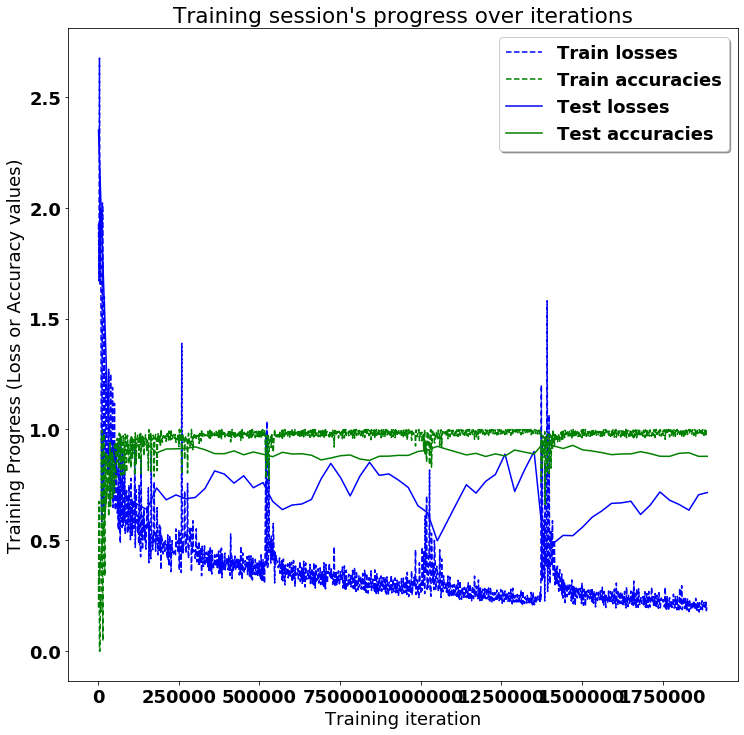

In [16]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

Testing Accuracy: 87.89398074150085%

Precision: 88.04954217089306%
Recall: 87.89398280802291%
f1_score: 87.84551668942284%

Confusion Matrix:
[[ 128    2    0   47]
 [   0  189    0   29]
 [   0    2 1079  221]
 [   0    3  203 2285]]

Confusion matrix (normalised to % of total test data):
[[3.0563514e+00 4.7755491e-02 0.0000000e+00 1.1222540e+00]
 [0.0000000e+00 4.5128942e+00 0.0000000e+00 6.9245464e-01]
 [0.0000000e+00 4.7755491e-02 2.5764088e+01 5.2769818e+00]
 [0.0000000e+00 7.1633242e-02 4.8471823e+00 5.4560650e+01]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


<Figure size 864x864 with 0 Axes>

Text(0.5, 1.0, 'Confusion matrix \n(normalised to % of total test data)')

([<matplotlib.axis.XTick at 0x12687985780>,
 <a list of 4 Text xticklabel objects>)

([<matplotlib.axis.YTick at 0x1268798b4e0>,
 <a list of 4 Text yticklabel objects>)

Text(-8.734375, 0.5, 'True label')

Text(0.5, 116.54562499999997, 'Predicted label')

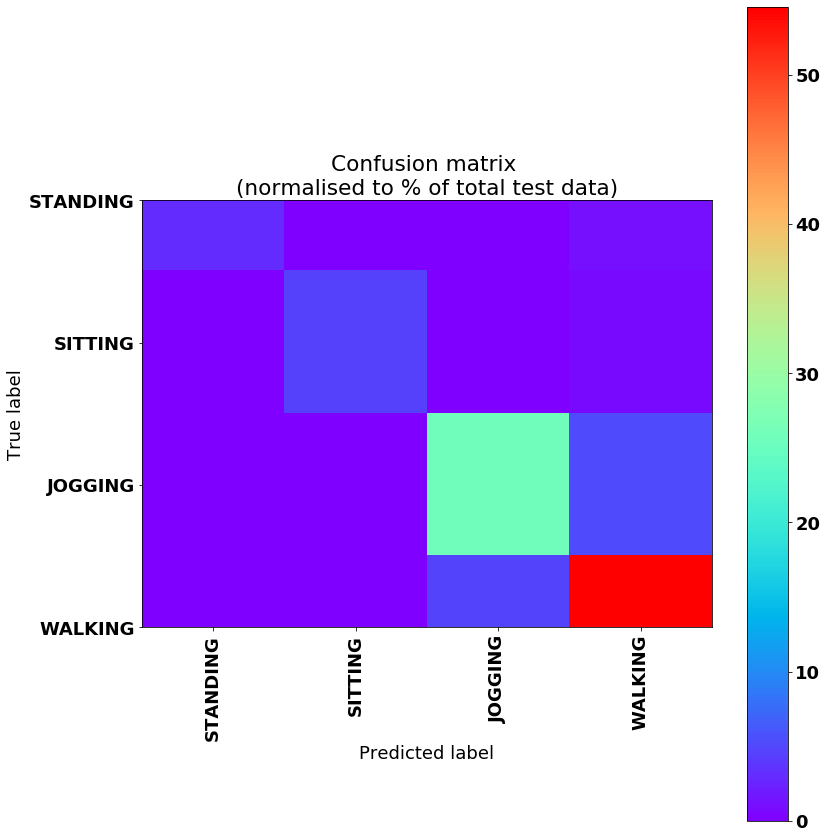

In [17]:
# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS) 
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [18]:
end_time1 = time.time()
elapsed_time1 = end_time1 - start_time1
print ("elapsed_time:{0}".format(elapsed_time1) + "[sec]")
print("total time train =", np.sum(train_time))
print("mean time train =", np.mean(train_time))
print("total time test =", np.sum(test_time))
print("mean time test =", np.mean(test_time))

elapsed_time:1866.115089893341[sec]
total time train = 104.4839825630188
mean time train = 1.658475913698711
total time test = 105.30795574188232
mean time test = 1.6715548530457511
